# Sheet 5

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## 2 Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/   
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [ ]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

In [ ]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

## 3 Log-sum-exp and soft(arg)max
### (b)

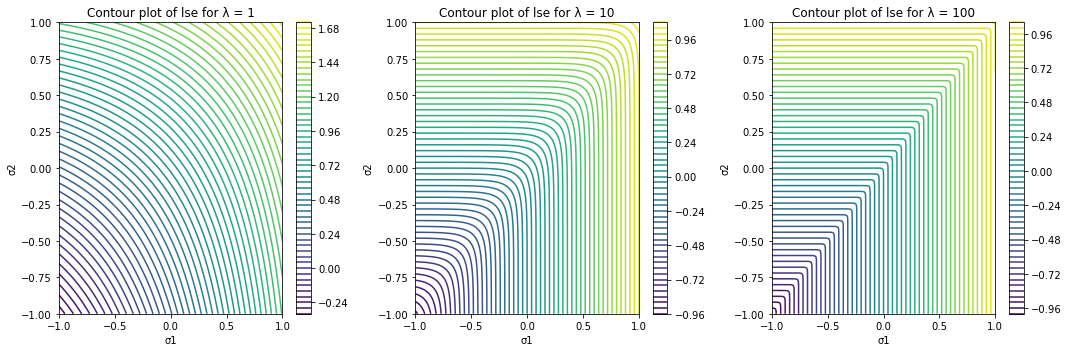

In [62]:
def lse(sig1, sig2, lamb):
    return np.log(np.exp(lamb * sig1) + np.exp(lamb * sig2)) / lamb
sig1_values = np.linspace(-1, 1, 200)
sig2_values = np.linspace(-1, 1, 200)
sig1_grid, sig2_grid = np.meshgrid(sig1_values, sig2_values)
lambdas = [1, 10, 100]

plt.figure(figsize=(15, 5))

for i, lamb in enumerate(lambdas):
    plt.subplot(1, 3, i + 1)
    z = lse(sig1_grid, sig2_grid, lamb)
    contour = plt.contour(sig1_grid, sig2_grid, z, levels=50, cmap='viridis')
    plt.colorbar(contour)
    plt.title(f'Contour plot of lse for λ = {lamb}')
    plt.xlabel('σ1')
    plt.ylabel('σ2')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'σ2')

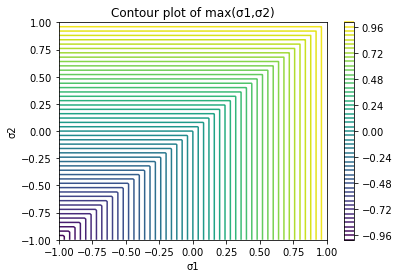

In [64]:
z2 = np.maximum(sig1_grid, sig2_grid)
contour = plt.contour(sig1_grid, sig2_grid, z2, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title(f'Contour plot of max(σ1,σ2)')
plt.xlabel('σ1')
plt.ylabel('σ2')

As we can see, the bigger lambda is, the closer we get to the max() function. This is because when lambda grows, one of the exponentials becomes the dominant one and the other is negligible.

### (c)

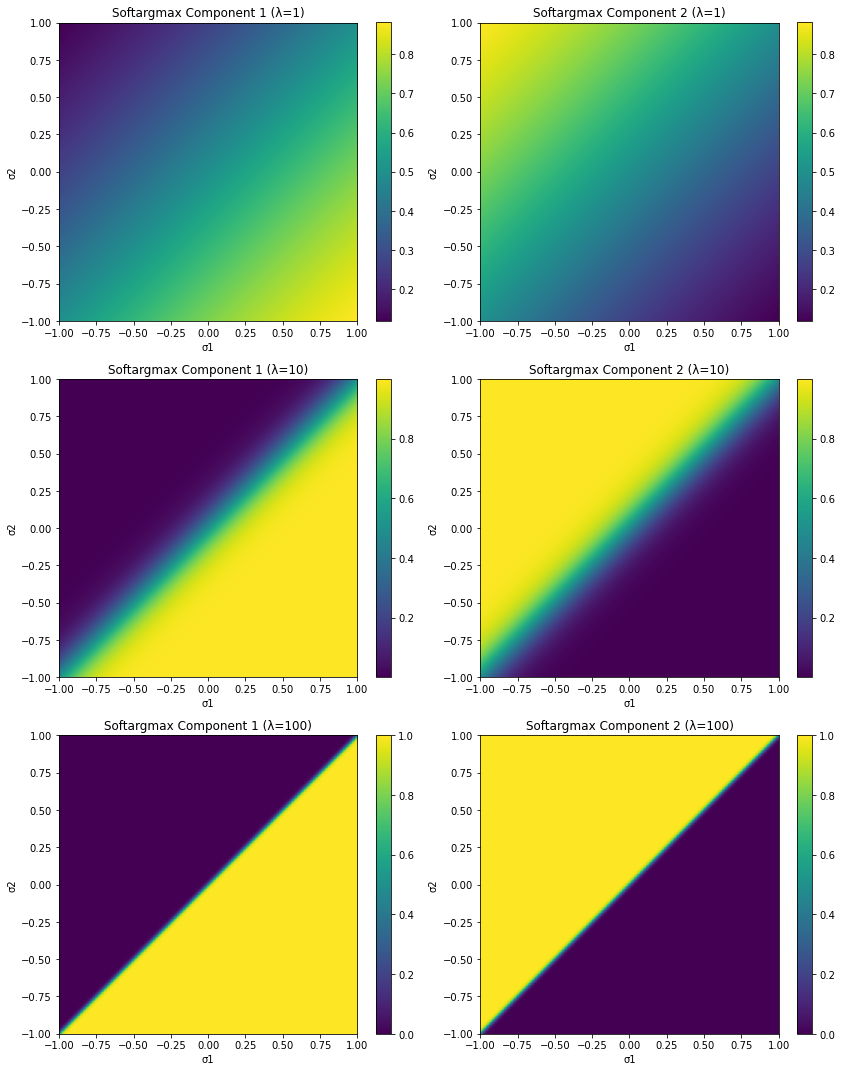

In [78]:
def softargmax(sig1, sig2, lambd):
    exp_sig1 = np.exp(lambd * sig1)
    exp_sig2 = np.exp(lambd * sig2)
    den = exp_sig1 + exp_sig2
    return exp_sig1/den, exp_sig2/den


fig, axes = plt.subplots(len(lambdas), 2, figsize=(12, 15))
for i, lambd in enumerate(lambdas):

    Z1, Z2 = softargmax(sig1_grid,sig2_grid, lambd)

    im1 = axes[i, 0].imshow(Z1, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    axes[i, 0].set_title(f"Softargmax Component 1 (λ={lambd})")
    axes[i, 0].set_xlabel("σ1")
    axes[i, 0].set_ylabel("σ2")
    fig.colorbar(im1, ax=axes[i, 0])

    im2 = axes[i, 1].imshow(Z2, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    axes[i, 1].set_title(f"Softargmax Component 2 (λ={lambd})")
    axes[i, 1].set_xlabel("σ1")
    axes[i, 1].set_ylabel("σ2")
    fig.colorbar(im2, ax=axes[i, 1])

plt.tight_layout()

plt.show()
plt.show()

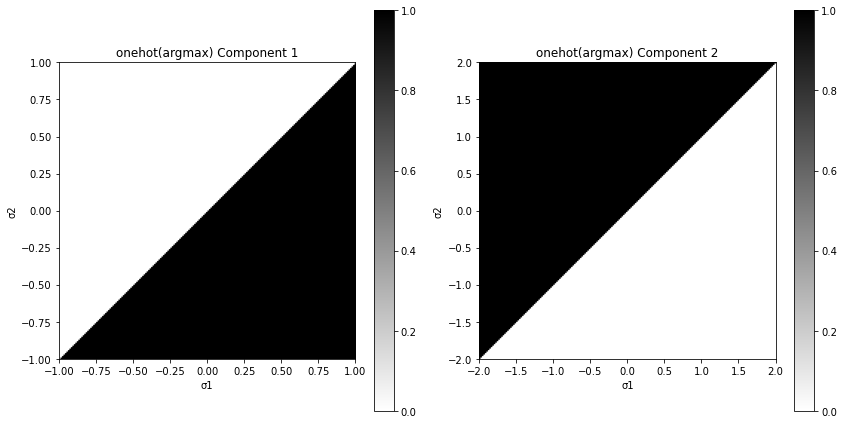

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [101]:
def onehot_argmax(sig1, sig2):
    argmax_1 = (sig1 > sig2).astype(float)  
    argmax_2 = (sig2 >= sig1).astype(float)  
    return argmax_1, argmax_2

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
x, y = onehot_argmax(sig1_grid,sig2_grid)

im11 = axes[0].imshow(x, extent=(-1, 1, -1, 1), origin='lower', cmap='binary')
axes[0].set_title("onehot(argmax) Component 1")
axes[0].set_xlabel("σ1")
axes[0].set_ylabel("σ2")
fig.colorbar(im11, ax=axes[0])


im12 = axes[1].imshow(y, extent=(-2, 2, -2, 2), origin='lower', cmap='binary')
axes[1].set_title("onehot(argmax) Component 2")
axes[1].set_xlabel("σ1")
axes[1].set_ylabel("σ2")
fig.colorbar(im12, ax=axes[1])



plt.tight_layout()

plt.show()

plt.tight_layout()

plt.show()

plt.tight_layout()

plt.show()
plt.show()

As we can see, the smaller lambda is the smoother is the transition. However, when lambda grows softargmax becomes to be closer to onehotargmax due to the fact that one of the exponentials is much bigger that the other, basically it happens the same as in the previous case.

## 4 Linear regions of MLPs